## To do list:

* Figure out why pits R1C1, SFPit1 and SPMS will not import correctly
* BGZOB water potential and reduction potential should be nan at the beginning, not 0
* Some 0s should be nan for Calhoun
* Also, if a site has a variable (such as soil moisture) at one depth but CO2 at 2 depths, then we will get 0s instead of nan for the depth where we have CO2 but not soil moisture.
* Everything checks out except for the 0s that should be nan. I think these 0s come when a site does not have a variable (happens alot with water potential and reduction potential), so the code seems to just add a column of 0s for those sites

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

# sites is a list of locations (e.g., "Calhoun"),
# all_pits is a dict with sites as keys, and lists of pits 
# at each site as the values
all_pits = {}
sites = os.listdir('../../processed_data')

# Loop through all sites to construct dict of sites/pits
for site in sites:
    cur_pits = []
    for pro_file in os.listdir(os.path.join('../../processed_data/', site)):
        cur_pits.append(pro_file.split('_')[0])
        
    all_pits[site] = cur_pits

# Data will be a dict with pits as keys, np arrays as values
data = {}
# This is a list of all the features for R1C1. We'll want to make this an exhaustive list
# of all potential features across all pits
features = ['CO2', 'precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'WaterPotential', 'ReductionPotential']
m = len(features)

# Load in and merge all files
# NOTE: Only doing Calhoun R1C1 for now, but you get the idea
i = 0
for site in all_pits.keys():
    for pit in all_pits[site]:
        
        if pit not in ['R1C2', 'SFPit1', 'SPMS']:
            infile = os.path.join('../../processed_data', site, '%s_processed.csv' % pit)
            df = pd.read_csv(infile, parse_dates=[0], index_col=0, na_values=[-99999])
            depths = [col.split('_')[1].split('cm')[0] for col in df.columns]
            depths = [d for d in depths if d != 'precip.mm']
            unique_depths = list(set(depths))

            # t is the number of time steps
            t = df.shape[0]

            # data shape is the # of observations (# time points * depths), # features
            cur_data = np.empty((t*len(unique_depths), m), dtype=float)

            for i, depth in enumerate(unique_depths):
                depth_cols = [col for col in df.columns if '_%scm' % depth in col]
                for j, feature in enumerate(features):
                    # Look for columns with this feature and depth in the name
                    if feature == 'precip':
                        col = 'PRISM_precip.mm'
                    else:
                        matches = [col for col in depth_cols if feature in col]

                        # Correct for fact that "O2" search returns "CO2" as well
                        if feature == 'O2':
                            matches = [col for col in matches if 'CO2' not in col]

                        if len(matches) > 1:
                            raise ValueError("""More than one possible match found for %s %s %scm %s""" %(site, pit, depth, feature))
                        elif len(matches) == 1:
                            col = matches[0]
                        else:
                            continue

                    # Finally, now that we have the column name
                        if np.all(cur_data[:,j]==0)==True:
                            cur_data[:,j]=np.nan       
                    cur_data[i*t:(i+1)*t, j] = df[col].values
                    cur_data[:,6]=np.nan
                if np.all(cur_data[:,j]==0)==True:
                        cur_data[:,j]=np.nan
            data[pit] = cur_data.copy()

In [13]:
if np.all(cur_data[:,7]==0):
    print ('True')
else:
    print ('False')
#np.all(cur_data[:,1])==0   
# np.all(cur_data[:,6])

False


In [56]:
merged=np.vstack(( data['R1C1'], data['R1H1'], data['R1P1'],  data['TMMS'], data['LRMS'], data['NPMS'], data['SPVF'], data['BGZOB1'], data['BGZOB2'], data['BGZOB3'], data['BGZOB4'], data['Green1'], data['Green2'], data['Green3'], data['MC1'], data['MC2'], data['MC3'], data['MC4'], data['MC5'], data['MC6']))
#
df=pd.DataFrame(data=merged, columns=['CO2', 'Precip', 'SoilMoisture', 'BulkEC', 'Temp', 'O2', 'WaterPotential', 'ReductionPotential'])

In [57]:
df.dropna(subset=['CO2'], inplace=True)
df

,CO2,Precip,SoilMoisture,BulkEC,Temp,O2,WaterPotential,ReductionPotential
0,7495.00000,NaN,NaN,NaN,15.99,18.988224,NaN,NaN
1,7715.00000,0.0,NaN,NaN,15.99,18.761198,NaN,NaN
2,7910.00000,0.0,NaN,NaN,15.99,18.761198,NaN,NaN
3,7875.00000,0.0,NaN,NaN,15.99,18.761198,NaN,NaN
4,8325.00000,0.0,NaN,NaN,15.99,18.587071,NaN,NaN
...,...,...,...,...,...,...,...,...
2691424,788.88775,NaN,NaN,NaN,NaN,NaN,NaN,597.850
2691425,793.57400,NaN,NaN,NaN,NaN,NaN,NaN,599.225
2691426,793.09225,NaN,NaN,NaN,NaN,NaN,NaN,597.750
2691427,800.28000,NaN,NaN,NaN,NaN,NaN,NaN,598.275


In [65]:
df['ReductionPotential'].isna().sum()

802771

In [4]:
final_array=df.to_numpy()
output=final_array.copy()
outfile = '../../merged_processed_data/MergeProcessedData.csv'
#output.to_csv(outfile, na_rep=-99999, index_label='record', float_format='%.3f')
np.savetxt(outfile, output, fmt='%.4f', delimiter=",")


In [27]:
df=df.drop(columns='WaterPotential')

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [20]:
df_med=df.fillna(df.median())
df_med=df_med.drop(columns='WaterPotential')
df_st =  StandardScaler().fit_transform(df_med) 

C:\Users\marcb\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1544: RuntimeWarning: overflow encountered in multiply
  sqr = np.multiply(arr, arr, out=arr)


In [51]:
df.interpolate(axis=1, inplace=True)

In [70]:
df_st1

,CO2,Precip,Soil Moisture,Bulk EC,Temp,O2,Reduction Potential
0,0.465643,-0.38215,-0.0,-0.0,1.237480,0.842040,-0.0
1,0.501042,-0.38215,-0.0,-0.0,1.237480,0.783114,-0.0
2,0.532419,-0.38215,-0.0,-0.0,1.237480,0.783114,-0.0
3,0.526787,-0.38215,-0.0,-0.0,1.237480,0.783114,-0.0
4,0.599195,-0.38215,-0.0,-0.0,1.237480,0.737919,-0.0
...,...,...,...,...,...,...,...
1483914,-0.613406,-0.38215,-0.0,-0.0,-0.056809,0.261098,-0.0
1483915,-0.612652,-0.38215,-0.0,-0.0,-0.056809,0.261098,-0.0
1483916,-0.612730,-0.38215,-0.0,-0.0,-0.056809,0.261098,-0.0
1483917,-0.611573,-0.38215,-0.0,-0.0,-0.056809,0.261098,-0.0


In [21]:
df_st1=pd.DataFrame(data=df_st)
#df_med = df_st1.fillna(df_st1.median())
pca = PCA(.95)
pca.fit(df_st1)

PCA(n_components=0.95)

In [23]:
pca.explained_variance_ratio_

array([0.35979931, 0.26275566, 0.23317821, 0.14426682])

In [28]:
pca_out=pca
loadings = pca_out.components_
num_pc = pca_out.n_features_
pc_list = ["PC"+str(i) for i in list(range(1, num_pc+1))]
loadings_df = pd.DataFrame.from_dict(dict(zip(pc_list, loadings)))
loadings_df['variable'] = df.columns.values
loadings_df = loadings_df.set_index('variable')
loadings_df

,PC1,PC2,PC3,PC4
variable,,,,
CO2,6.741425e-01,1.029156e-01,-2.709131e-01,6.793721e-01
Precip,1.561164e-01,6.829567e-01,7.131074e-01,2.599239e-02
SoilMoisture,-1.110223e-16,5.606626e-15,2.109424e-15,1.387779e-16
BulkEC,-0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00
Temp,6.975681e-01,-6.025400e-02,-6.910603e-02,-7.106282e-01
O2,1.858986e-01,-7.206580e-01,6.428906e-01,1.810677e-01
ReductionPotential,0.000000e+00,0.000000e+00,-0.000000e+00,0.000000e+00


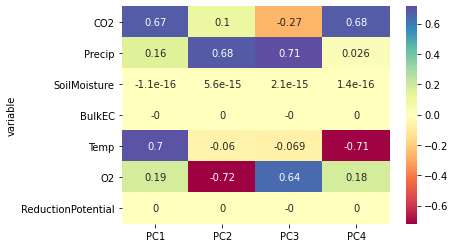

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(loadings_df, annot=True, cmap='Spectral')
plt.show()

In [71]:
pca_scores = PCA().fit_transform(df_st1)

In [72]:
import bioinfokit
from bioinfokit.visuz import cluster
cluster.biplot(cscore=pca_scores, loadings=loadings, labels=df.columns.values, var1=round(pca_out.explained_variance_ratio_[0]*100, 2),
var2=round(pca_out.explained_variance_ratio_[1]*100, 2))

In [73]:
cluster.biplot(cscore=pca_scores, loadings=loadings, labels=df.columns.values, 
    var1=round(pca_out.explained_variance_ratio_[0]*100, 2), var2=round(pca_out.explained_variance_ratio_[1]*100, 2), 
    var3=round(pca_out.explained_variance_ratio_[2]*100, 2))

In [44]:
df_st1.columns=['CO2', 'Precip','Soil Moisture', 'Bulk EC', 'Temp', 'O2', 'Reduction Potential']

In [45]:
from sklearn.model_selection import train_test_split

X=df_st1[['Precip', 'Soil Moisture', 'Bulk EC', 'Temp', 'O2', 'Reduction Potential']]  # Features\n",
y=df_st1['CO2']  # Labels\n",

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
from sklearn.svm import LinearSVR
from sklearn import svm
regr = svm.LinearSVR(max_iter=5000)
regr.fit(X_train, y_train)
from sklearn import metrics
regr.score(X_test, y_test)

0.062402694413982274